# Experiment With Rommel's Data

This notebook performs some prior predictive checks for a mixed effects pharmacokinetic regression model.  The posterior for this model will then be summarized and used as a prior for future experiments.

In [1]:
%load_ext blackcellmagic

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
import arviz as az

from utils.regression_models import regression_model_factory
from utils.models import model_factory
from utils.tools import  summarize_posterior, summarize_ppc

import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
model_data = pd.read_csv('data/apixiban_regression_data.csv')

yobs = model_data.Concentration_scaled.values
subject_ids = pd.Categorical(model_data.Subject).codes 
times = model_data.Time.values


In [3]:
from sklearn.preprocessing import StandardScaler

covars = model_data.drop_duplicates("Subject").loc[:,['Sex', 'Creatinine', 'Age']]
covars['Sex'] = covars.Sex.apply(lambda x: 1 if x=='Male' else 0)


X = covars.values
X[:,1:] = StandardScaler().fit_transform(X[:,1:])

In [4]:
model_data.head()

,Time,Subject,Concentration,Group,Sex,Concentration_scaled,Age,Weight,Creatinine,BMI
0,0.5,1,0.7,NAFLD,Male,0.0007,31,63.5,86.0,23.3
1,1.0,1,32.7,NAFLD,Male,0.0327,31,63.5,86.0,23.3
2,2.0,1,79.7,NAFLD,Male,0.0797,31,63.5,86.0,23.3
3,4.0,1,59.2,NAFLD,Male,0.0592,31,63.5,86.0,23.3
4,6.0,1,42.2,NAFLD,Male,0.0422,31,63.5,86.0,23.3


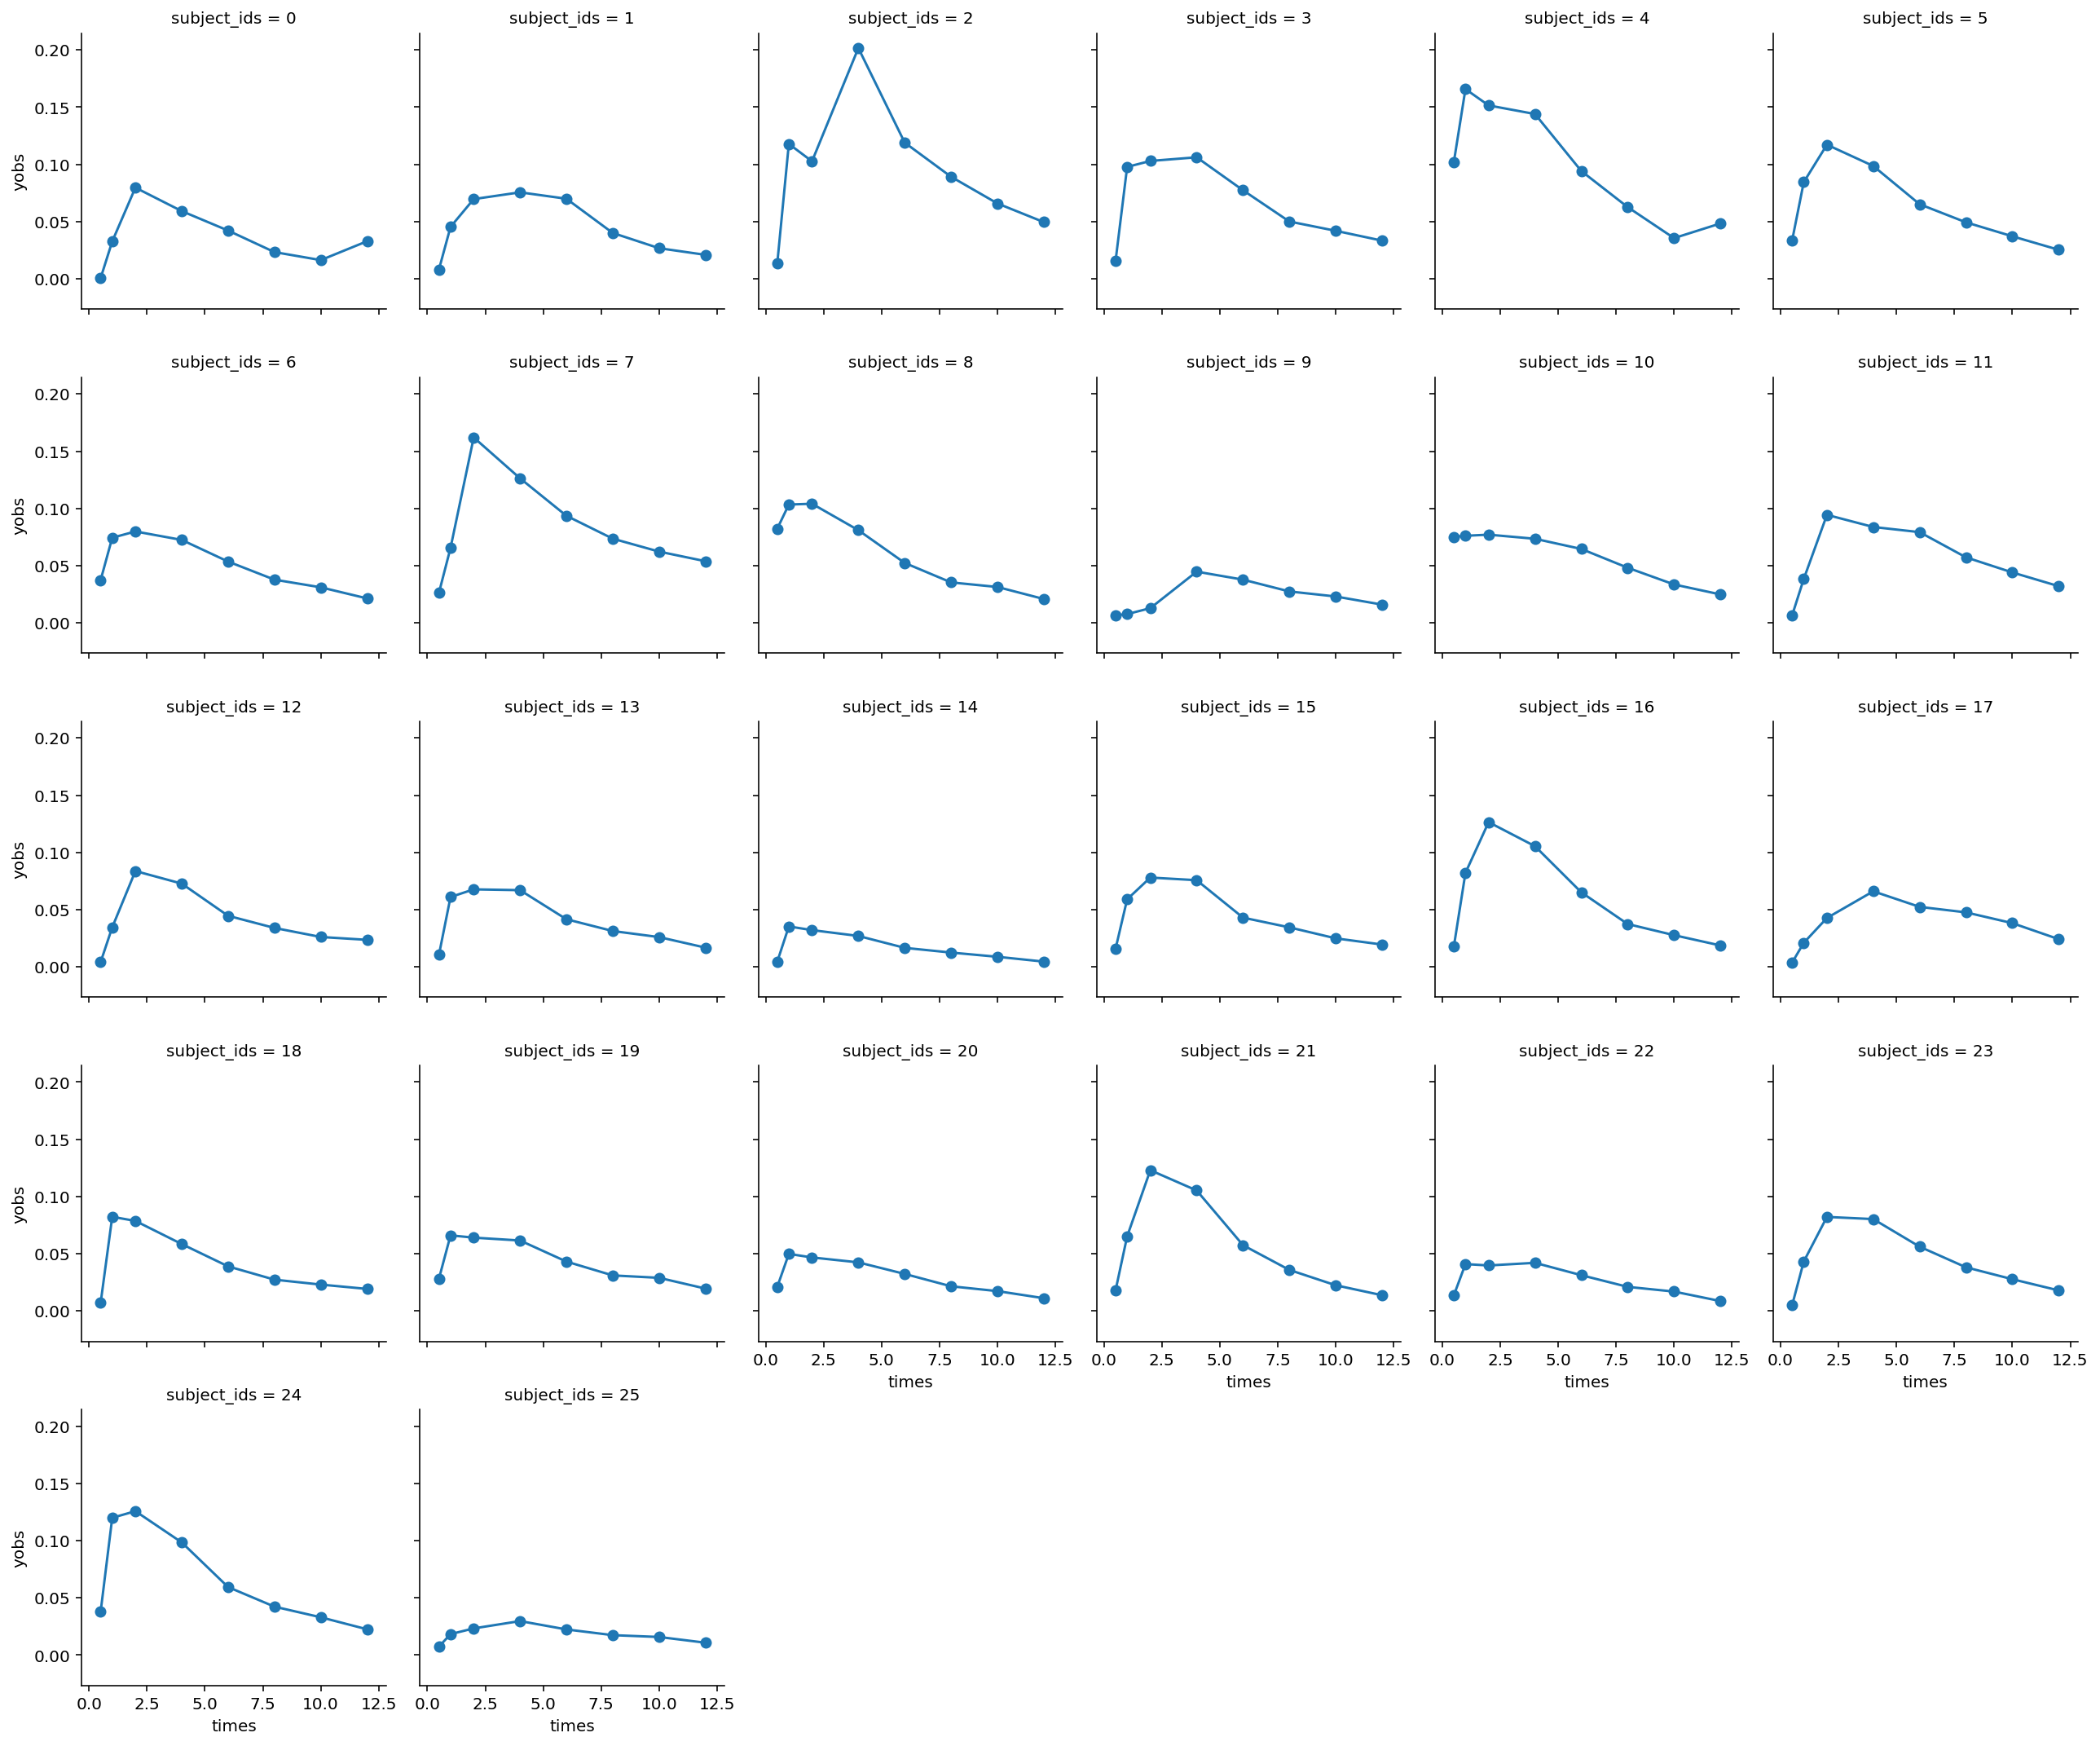

In [5]:
df = pd.DataFrame({'yobs':yobs,
                   'times':times,
                   'subject_ids':subject_ids})

g = sns.FacetGrid(data = df.query('subject_ids<=25'), col='subject_ids', col_wrap=6)

g.map(plt.scatter, 'times','yobs', color = 'C0')
g.map(plt.plot, 'times','yobs', color = 'C0')


# Mixed Effect Models

In [6]:
with model_factory(yobs, times, subject_ids) as mixed_effects_model:
    prior_predictive = pm.sample_prior_predictive(1000)
    trace = pm.sample(draws=1, tune=1, chains = 1)

    model = az.from_pymc3(prior = prior_predictive, 
                          trace = trace, 
                          coords = {'subject_ids':np.sort(np.unique(subject_ids)) },
                                dims = {'ke':['subject_ids'],
                                        'Cl':['subject_ids'],
                                        'ka':['subject_ids'],
                                        'delays':['subject_ids']})
    

Only 1 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, delays, delays_kappa, delays_mu, z_ka, sigma_ka, z_ke, sigma_ke, z, z_CL, sigma_CL, mu_CL]
Sampling chain 0, 0 divergences: 100%|██████████| 2/2 [00:00<00:00,  9.82it/s]
/Users/demetri/miniconda3/lib/python3.7/site-packages/pymc3/sampling.py:496: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The chain contains only diverging samples. The model is probably misspecified.


# Model Priors

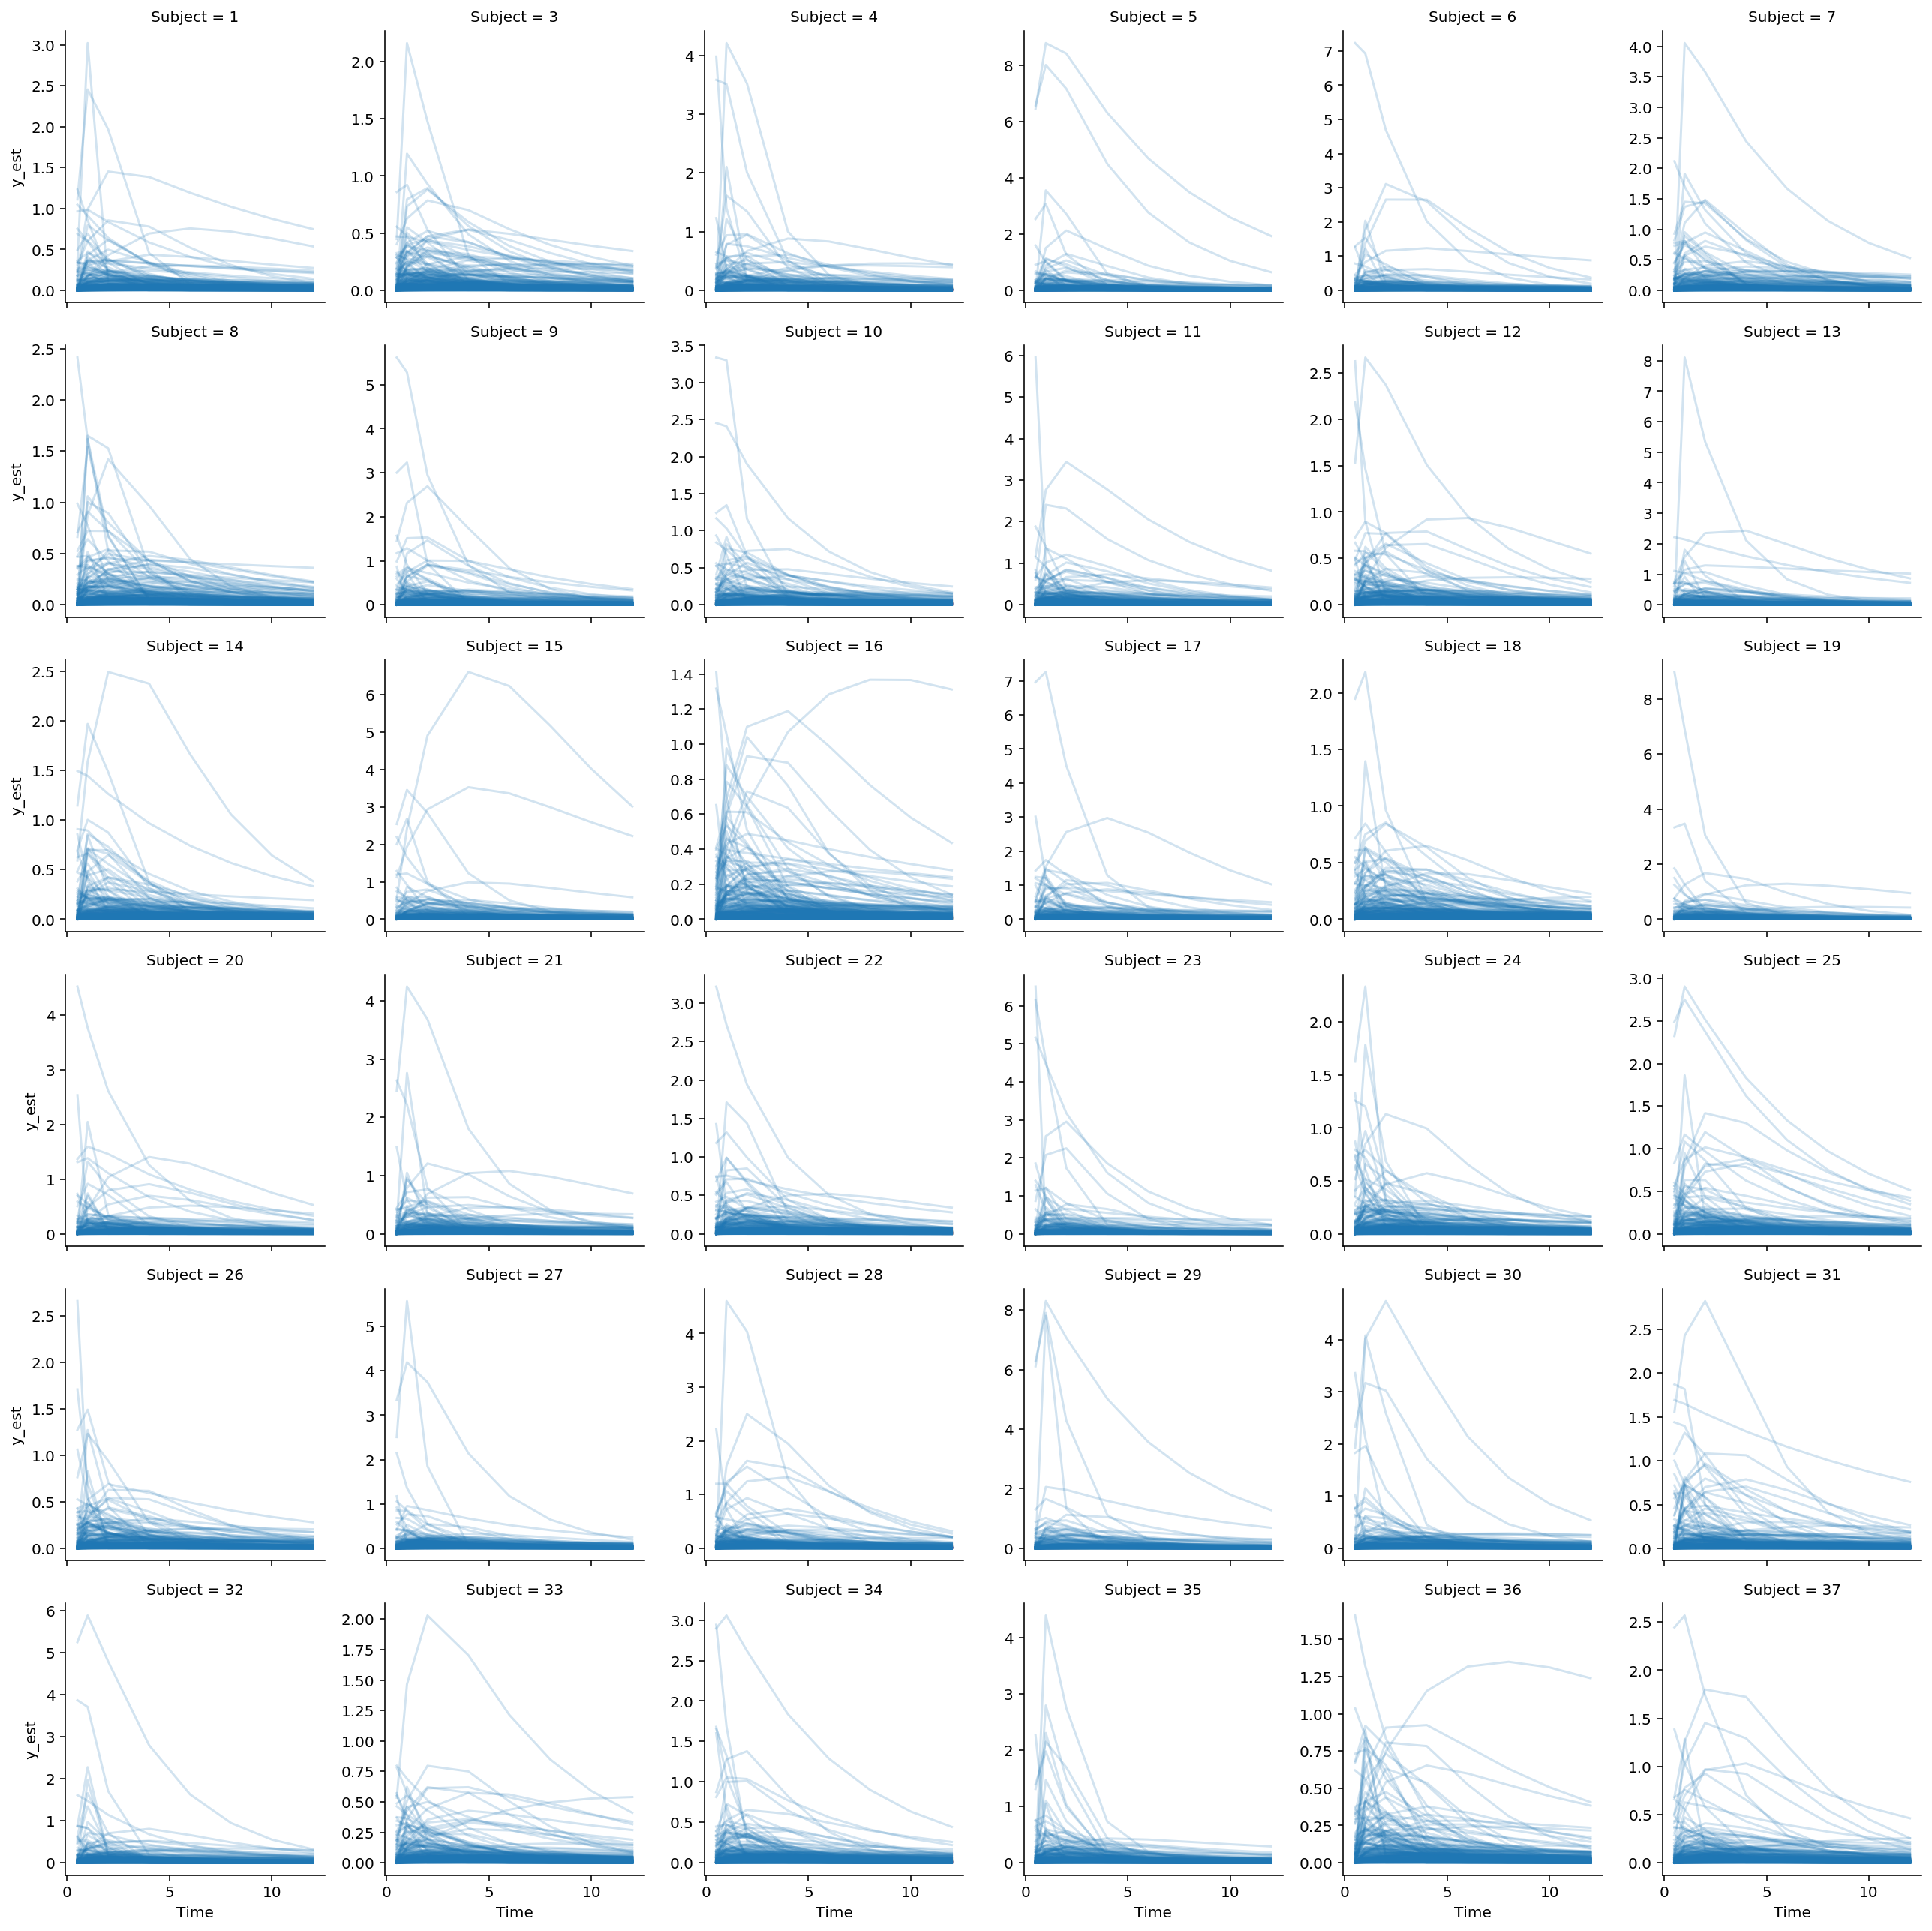

In [7]:
model_prior = model.prior.y_est.to_dataframe().query('draw<200')
dfsub = model_data.loc[:,['Time','Subject']]
replicates = pd.merge(dfsub, model_prior, left_index=True, right_on='y_est_dim_0').reset_index('draw')

g = sns.FacetGrid(data = replicates, col='Subject', col_wrap=6, sharey = False)
g.map_dataframe(sns.lineplot,'Time','y_est',estimator=None, units='draw', alpha = 0.2)

# Fit Mixed Effects Model

In [ ]:
with mixed_effects_model:
    trace = pm.sample(draws=1000, tune=1000, chains = 12)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    me_model = az.from_pymc3(prior = prior_predictive, 
                          trace = trace, 
                          posterior_predictive = posterior_predictive,
                          coords = {'subject_ids':np.sort(np.unique(subject_ids)) },
                                dims = {'ke':['subject_ids'],
                                        'Cl':['subject_ids'],
                                        'ka':['subject_ids'],
                                        'delays':['subject_ids']})
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 2 jobs)
NUTS: [sigma, delays, delays_kappa, delays_mu, z_ka, sigma_ka, z_ke, sigma_ke, z, z_CL, sigma_CL, mu_CL]
Sampling 12 chains, 0 divergences:  20%|█▉        | 4751/24000 [01:43<05:14, 61.28draws/s]  

# Model Fit

In [ ]:
predictions = summarize_posterior(me_model.posterior, 'y_est', 'pred')
ppc = summarize_ppc(me_model.posterior_predictive,'Yobs','ppc')

dfpred = df.join(predictions).join(ppc)

g = sns.FacetGrid(data = dfpred, col='subject_ids', col_wrap=6, sharey = True)
g.map(plt.scatter, 'times','yobs', color = 'C0')
g.map(plt.plot, 'times','pred_pred', color = 'C1')
g.map(plt.fill_between,'times','pred_low','pred_high',alpha = 0.5, color = 'C1')
g.map(plt.fill_between,'times','ppc_low','ppc_high',alpha = 0.25, color = 'C1')

In [ ]:
model_prior = me_model.posterior_predictive.Yobs.to_dataframe().query('draw<5 and chain==1')
dfsub = df.loc[:,['times','subject_ids']]
replicates = pd.merge(dfsub, model_prior, left_index=True, right_on='Yobs_dim_0').reset_index('draw')

g = sns.FacetGrid(data = replicates, col='subject_ids', col_wrap=6, sharey = True)
g.map_dataframe(sns.lineplot,'times','Yobs',estimator=None, units='draw')

# Regression Models

In [ ]:
with regression_model_factory(yobs, X, times, subject_ids, use_delay = True) as regression_model:
    prior_predictive = pm.sample_prior_predictive(500)
    trace = pm.sample(draws=1, tune=1, chains = 1)

    model = az.from_pymc3(prior = prior_predictive, 
                          trace = trace, 
                          coords = {'subject_ids':np.sort(np.unique(subject_ids)) },
                                dims = {'ke':['subject_ids'],
                                        'Cl':['subject_ids'],
                                        'ka':['subject_ids'],
                                        'delays':['subject_ids']})

# Model Prior

In [ ]:
model_prior = model.prior.y_est.to_dataframe().query('draw<100')
dfsub = model_data.loc[:,['Time','Subject']]
replicates = pd.merge(dfsub, model_prior, left_index=True, right_on='y_est_dim_0').reset_index('draw')

g = sns.FacetGrid(data = replicates, col='Subject', col_wrap=6, sharey = False)
g.map_dataframe(sns.lineplot,'Time','y_est',estimator=None, units='draw', alpha = 0.2)

# Fit Regression Model

In [ ]:
with regression_model:
    trace = pm.sample(draws=1000, tune=1000, chains = 4)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    reg_model = az.from_pymc3(prior = prior_predictive, 
                          trace = trace, 
                          posterior_predictive = posterior_predictive,
                          coords = {'subject_ids':np.sort(np.unique(subject_ids)) },
                                dims = {'ke':['subject_ids'],
                                        'Cl':['subject_ids'],
                                        'ka':['subject_ids'],
                                        'delays':['subject_ids']})

In [ ]:
predictions = summarize_posterior(reg_model.posterior, 'y_est', 'pred')
ppc = summarize_ppc(reg_model.posterior_predictive,'Yobs','ppc')

dfpred = df.join(predictions).join(ppc)

g = sns.FacetGrid(data = dfpred, col='subject_ids', col_wrap=6, sharey = True)
g.map(plt.scatter, 'times','yobs', color = 'C0')
g.map(plt.plot, 'times','pred_pred', color = 'C1')
g.map(plt.fill_between,'times','pred_low','pred_high',alpha = 0.5, color = 'C1')
g.map(plt.fill_between,'times','ppc_low','ppc_high',alpha = 0.25, color = 'C1')

----

# Estimated From Tmax Model

In [ ]:
from utils.models import estimated_from_tmax
with estimated_from_tmax(yobs, times, subject_ids) as tmax:
    prior_predictive = pm.sample_prior_predictive(1000)
    trace = pm.sample(draws=1, tune=1, chains = 1)

    model = az.from_pymc3(prior = prior_predictive, 
                          trace = trace, 
                          coords = {'subject_ids':np.sort(np.unique(subject_ids)) },
                                dims = {'ke':['subject_ids'],
                                        'Cl':['subject_ids'],
                                        'ka':['subject_ids'],
                                        'delays':['subject_ids']})
    

In [ ]:
model_prior = model.prior.y_est.to_dataframe().query('draw<200')
dfsub = model_data.loc[:,['Time','Subject']]
replicates = pd.merge(dfsub, model_prior, left_index=True, right_on='y_est_dim_0').reset_index('draw')

g = sns.FacetGrid(data = replicates, col='Subject', col_wrap=6)
g.map_dataframe(sns.lineplot,'Time','y_est',estimator=None, units='draw', alpha = 0.2)

In [ ]:
with tmax:
    trace = pm.sample(draws=1000, tune=1000, chains = 4)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    model = az.from_pymc3(prior = prior_predictive, 
                          trace = trace, 
                          posterior_predictive = posterior_predictive,
                          coords = {'subject_ids':np.sort(np.unique(subject_ids)) },
                                dims = {'ke':['subject_ids'],
                                        'Cl':['subject_ids'],
                                        'ka':['subject_ids'],
                                        'delays':['subject_ids']})
    

In [ ]:
# predictions = summarize_posterior(model.posterior, 'y_est', 'pred')
# ppc = summarize_ppc(model.posterior_predictive,'Yobs','ppc')

# dfpred = df.join(predictions).join(ppc)

# g = sns.FacetGrid(data = dfpred, col='subject_ids', col_wrap=6, sharey = True)
# g.map(plt.scatter, 'times','yobs', color = 'C0')
# g.map(plt.plot, 'times','pred_pred', color = 'C1')
# g.map(plt.fill_between,'times','pred_low','pred_high',alpha = 0.5, color = 'C1')
# g.map(plt.fill_between,'times','ppc_low','ppc_high',alpha = 0.25, color = 'C1')

In [ ]:
# model_prior = model.posterior_predictive.Yobs.to_dataframe().query('draw<10 and chain==1')
# dfsub = df.loc[:,['times','subject_ids']]
# replicates = pd.merge(dfsub, model_prior, left_index=True, right_on='Yobs_dim_0').reset_index('draw')

# g = sns.FacetGrid(data = replicates, col='subject_ids', col_wrap=6, sharey = True)
# g.map_dataframe(sns.lineplot,'times','Yobs',estimator=None, units='draw')

In [ ]:
reg=reg_model.posterior.y_est.mean(axis = (0,1)).values
tmod = model.posterior.y_est.mean(axis = (0,1)).values

plt.scatter(yobs, tmod, marker = '.', alpha = 0.5)
x = np.linspace(0,0.2)
plt.plot(x,x)

In [ ]:
yobs = df.yobs

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(1000*yobs, 1000*reg)

In [ ]:
mean_squared_error(1000*yobs, 1000*tmod)

In [ ]:
x = model.posterior.delays_kappa.values.ravel()

In [ ]:
from scipy.stats import beta

np.log(x).std()

In [ ]:
beta.fit(x, floc=0, fscale=1)